Date: 2016-09-08

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
import os
import sys
import collections
import random
import itertools
import functools
import scipy.fftpack
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import tqdm

sys.path.append('../src/')
import data_filter as df
import ripples
import spectral

In [2]:
Animal = collections.namedtuple('Animal', {'directory', 'short_name'})
num_days = 8
days = range(1, num_days + 1)
animals = {'HPa': Animal(directory='HPa_direct', short_name='HPa')}

epoch_info = df.make_epochs_dataframe(animals, days)
tetrode_info = df.make_tetrode_dataframe(animals)
epoch_keys = df.get_dataframe_index(epoch_info
    .loc[(['HPa'], [8]), :]
    .loc[epoch_info.environment == 'wtr1'])

cur_tetrode_info = pd.concat([tetrode_info[key] for key in epoch_keys])
cur_tetrode_info

tetrode_index = df.get_dataframe_index(cur_tetrode_info)
lfp_data = df.get_LFP_data(tetrode_index, animals)

In [58]:
def butter_bandpass(lowcut, highcut, sampling_frequency, order=10):
    nyq = 0.5 * sampling_frequency
    low = lowcut / nyq
    high = highcut / nyq
    b, a = scipy.signal.butter(order, [low, high], btype='bandpass')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, sampling_frequency, order=5):
    b, a = butter_bandpass(lowcut, highcut, sampling_frequency, order=order)
    return scipy.signal.filtfilt(b, a, data)

def plot_current_segments(segments, time_extent, axis_handle, y_low=-5,
                          height=10, alpha=0.3, color='grey'):
    try:
        seg_in_extent = ((np.array(segments)[:,0] < time_extent[0]) &
                       (np.array(segments)[:,1] > time_extent[1]) > 0).nonzero()
        segs = list(np.array(segments)[seg_in_extent])
        for segment in segments:
                axis_handle.add_patch(ripples.create_box(segment,
                                                         y_low=y_low,
                                                         height=height,
                                                         alpha=alpha,
                                                         color=color))
    except IndexError:
        pass
    
def plot_ripple_metrics(ripple_df, ripple_number, sampling_frequency):    
    ripple_time = ripple_df[ripple_df.ripple_number == ripple_number].index
    ripple_extent = np.array([ripple_time.min(), ripple_time.max()])
    extended_ripple_extent = ripple_extent + [-0.400, 0.400]
    extended_ripple_df = ripple_df.loc[extended_ripple_extent[0]:extended_ripple_extent[1], :]

    extended_ripple_time = extended_ripple_df.index.get_values()
    
    fig, axis_handles = plt.subplots(6, 1, figsize=(12, 10))

    min_lfp = extended_ripple_df.electric_potential.min()
    max_lfp = extended_ripple_df.electric_potential.max()
    lfp_height = max_lfp - min_lfp

    # LFP
    extended_ripple_df.electric_potential.plot(ax=axis_handles[0], title='LFP')
    axis_handles[0].set_ylim((min_lfp, max_lfp))

    # Filter between 100-300 Hz
    filtered_data = butter_bandpass_filter(extended_ripple_df.electric_potential, 100, 300,
                                           sampling_frequency,
                                           order=6)
    axis_handles[1].plot(extended_ripple_time, filtered_data, label='filtered data (100-250 Hz)')
    axis_handles[1].set_title('Bandpass Filtered Signal (100-300 Hz)')

    # Multitaper Spectrogram
    frequency_resolution = 50
    time_window_duration = 0.080
    time_window_step = 0.010
    time_halfbandwidth_product = time_window_duration * (frequency_resolution / 2)
    spectrogram = spectral.get_spectrogram_dataframe(extended_ripple_df,
                                                     time_halfbandwidth_product=time_halfbandwidth_product,
                                                     time_window_duration=time_window_duration,
                                                     sampling_frequency=sampling_frequency,
                                                     time_window_step=time_window_step)
    spectral.plot_spectrogram(spectrogram, axis_handles[2])
    axis_handles[2].set_ylim((100, 300))
    axis_handles[2].hlines(150, extended_ripple_extent[0], extended_ripple_extent[1],
                           color='white', linestyle='--', linewidth=1)
    axis_handles[2].hlines(250, extended_ripple_extent[0], extended_ripple_extent[1],
                           color='white', linestyle='--', linewidth=1)
    axis_handles[2].set_title('Multitaper Spectrogram, Freq. Resolution={freq_res}, Time Window={time_win}'.format(
                              freq_res=frequency_resolution,
                              time_win=time_window_duration))

    # Multitaper Power
    multitaper_df = ripples.get_ripple_zscore_multitaper(extended_ripple_df,
                                                         sampling_frequency,
                                                         zscore_threshold=2)
    extended_ripple_multitaper_df = multitaper_df.loc[extended_ripple_extent[0]:extended_ripple_extent[1], :]
    extended_ripple_multitaper_df.power.plot(ax=axis_handles[3], title='Power at 200 Hz')
    power_extent = (extended_ripple_multitaper_df.power.min(),
                    extended_ripple_multitaper_df.power.max())
    axis_handles[3].set_ylim(power_extent)

    # Multitaper Z-Score
    extended_ripple_multitaper_df.ripple_zscore.plot(ax=axis_handles[4], title='Z-Score Power')
    axis_handles[4].hlines(2, extended_ripple_extent[0], extended_ripple_extent[1],
                           label='threshold', alpha=0.5)
    axis_handles[4].hlines(0, extended_ripple_extent[0], extended_ripple_extent[1],
                           label='mean baseline', linestyle='--', linewidth=1, alpha=0.5)
    axis_handles[4].set_ylim((-3, 7))

    # My Calculated Zscore
    zscore_df = ripples.get_ripple_zscore_frank(ripple_df,
                                                sampling_frequency,
                                                zscore_threshold=2)
    zscore_df = zscore_df.loc[extended_ripple_extent[0]:extended_ripple_extent[1], :]
    zscore_df.ripple_zscore.plot(ax=axis_handles[5], title='My Version of Frank Lab Z-Score')
    axis_handles[5].hlines(2, extended_ripple_extent[0], extended_ripple_extent[1],
                           label='threshold', alpha=0.5)
    axis_handles[5].hlines(0, extended_ripple_extent[0], extended_ripple_extent[1],
                           label='mean baseline', linestyle='--', linewidth=1, alpha=0.5)
    axis_handles[5].set_ylim((-3, 7))

    ## Label segment boxes
    # Grey Box = Computed Segements
    for axis_handle in np.concatenate((axis_handles[0:2], axis_handles[3:])):
        axis_handle.add_patch(ripples.create_box(tuple(ripple_extent),
                                                 y_low=min_lfp,
                                                 height=lfp_height,
                                                 alpha=0.3))

    # Blue Box = Multitaper Segment
    segments_multitaper = ripples.get_segments_multitaper(ripple_df,
                                                          sampling_frequency,
                                                          zscore_threshold=2)
    plot_current_segments(segments_multitaper, extended_ripple_extent, axis_handles[4],
                          y_low=min_lfp,
                          height=lfp_height,
                          color='green')

    # Red Box = My version of Computed Segment
    segments_frank = ripples.get_segments_frank(ripple_df,
                                          sampling_frequency,
                                          zscore_threshold=2)
    plot_current_segments(segments_frank, extended_ripple_extent, axis_handles[5],
                          y_low=min_lfp,
                          height=lfp_height,
                          color='red')
    for axis_handle in axis_handles:
        axis_handle.set_xlim(extended_ripple_extent + [0.100, -0.100])
    plt.tight_layout()

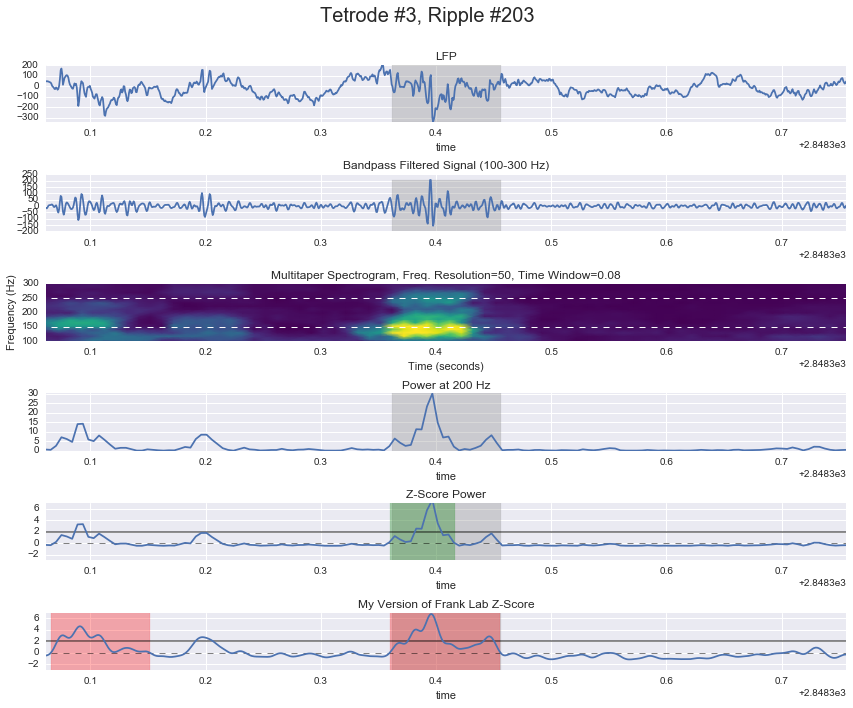

In [59]:
tetrode_numbers = range(1,8)
tetrode_number = random.sample(tetrode_numbers, 1)[0]
sampling_frequency = 1500

ripple_df = ripples.get_computed_ripples_dataframe(tetrode_index[tetrode_number - 1], animals)
ripple_numbers = list(ripple_df.ripple_number.unique())
ripple_number = random.sample(ripple_numbers, 1)[0]

plot_ripple_metrics(ripple_df, ripple_number, sampling_frequency)
plt.subplots_adjust(top=0.90)
plt.suptitle('Tetrode #{tetrode_number}, Ripple #{ripple_number}'.format(tetrode_number=tetrode_number,
                                                                         ripple_number=int(ripple_number)),
             fontsize=20)


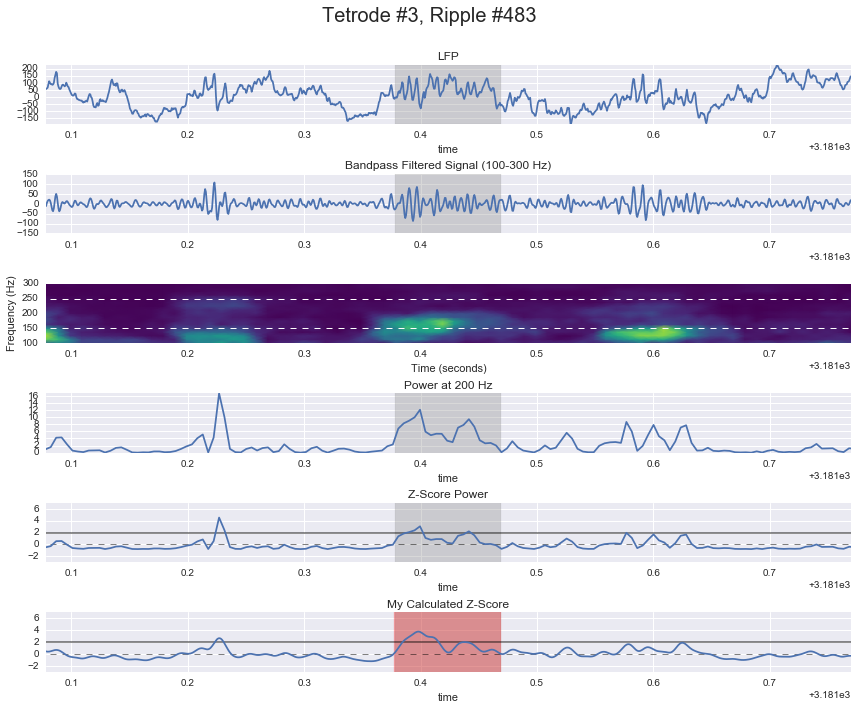

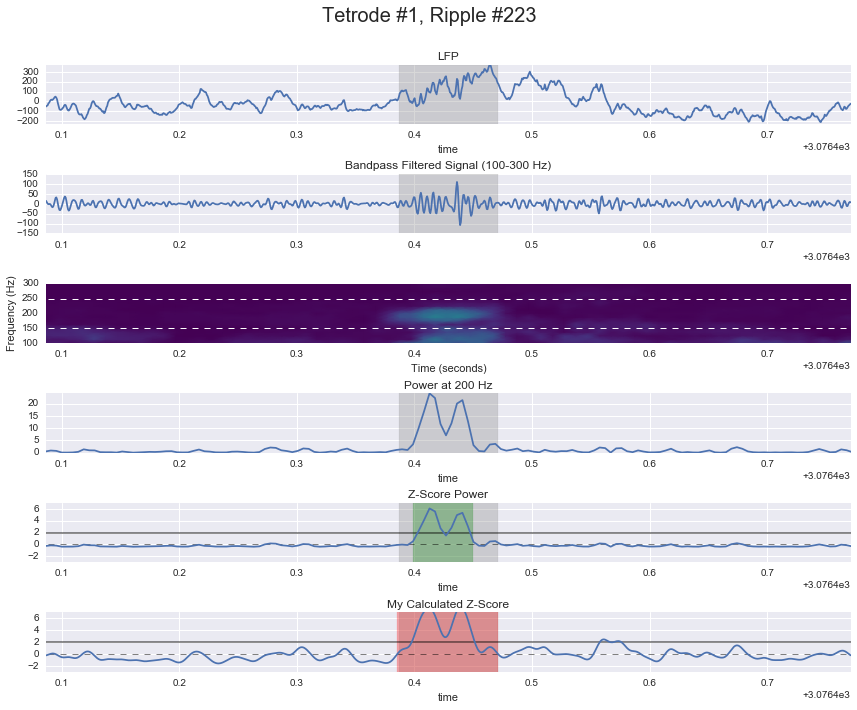

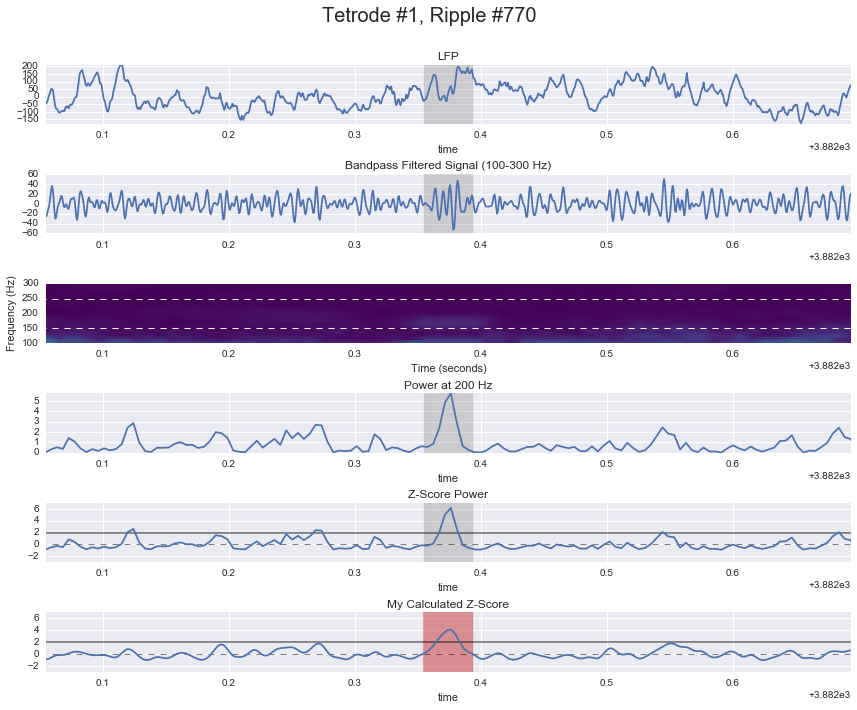

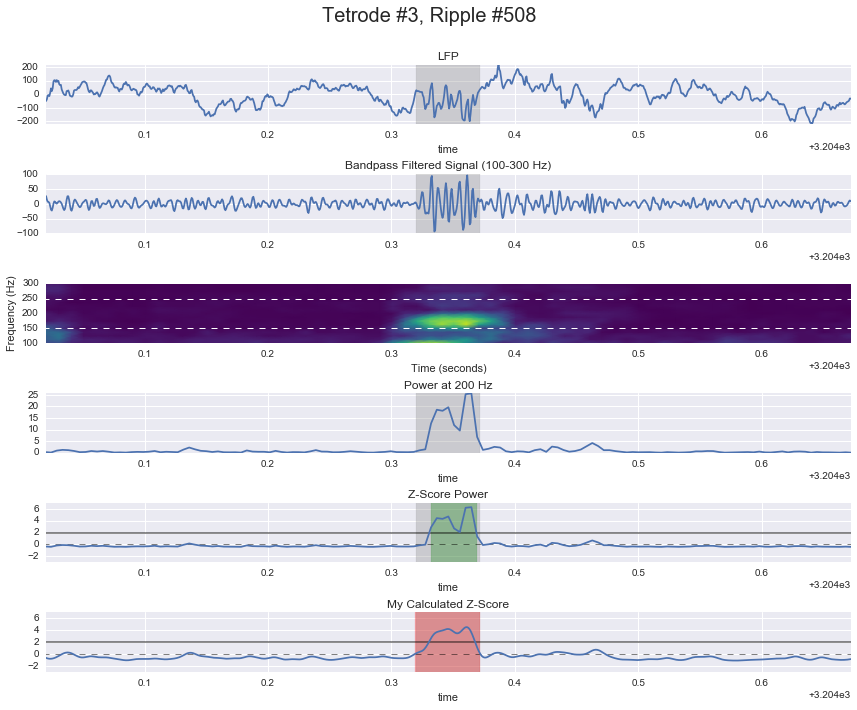

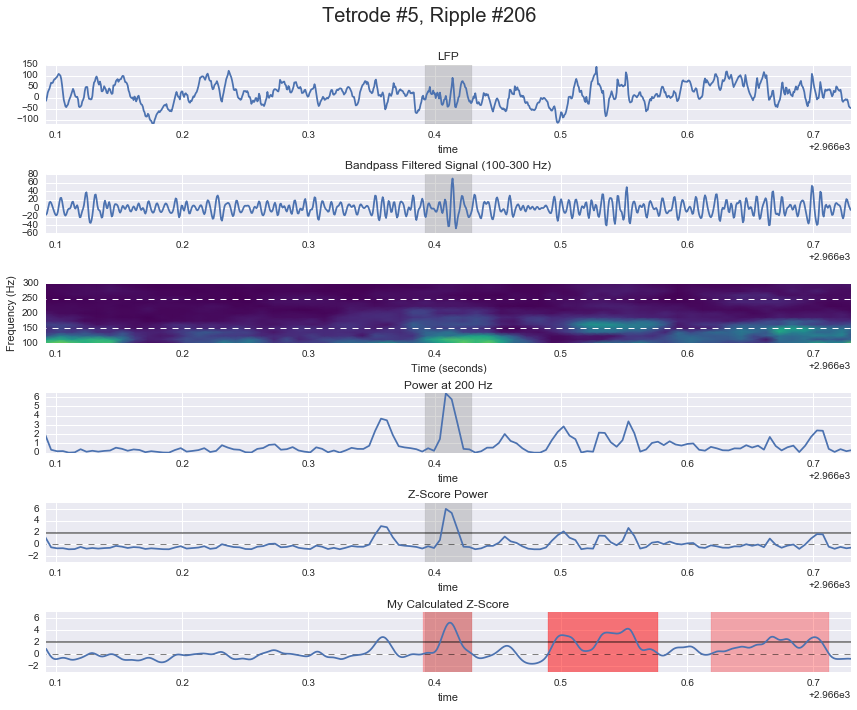

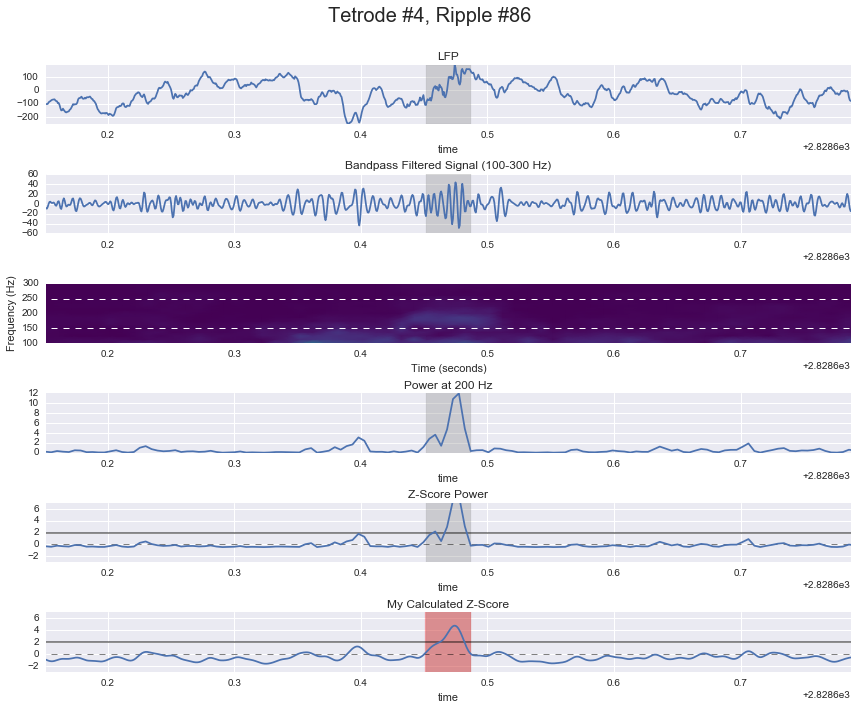

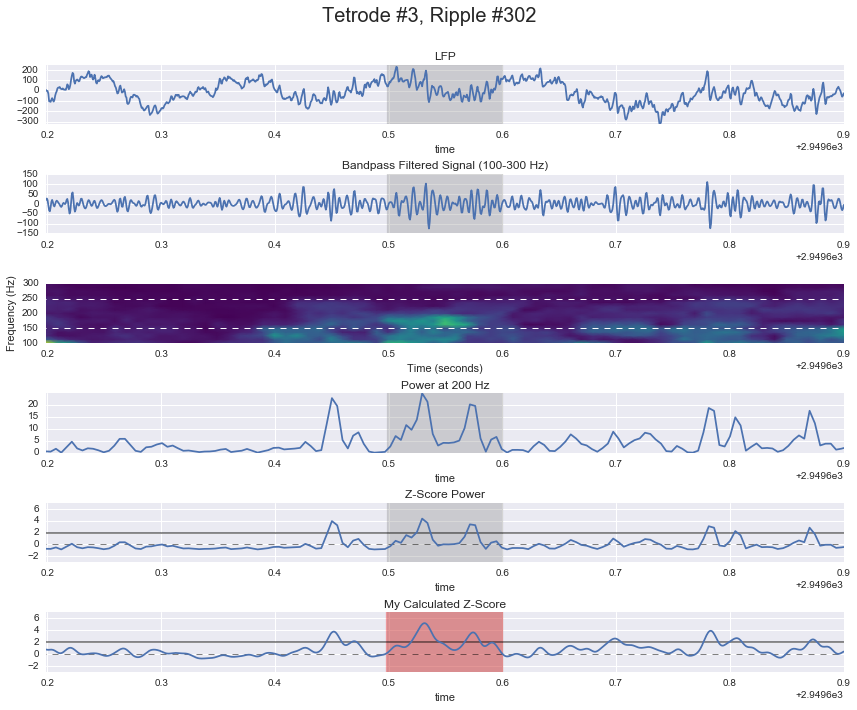

In [139]:
example_ripples = [(3, 483), (1, 223), (1, 770), (3, 508), (5, 206), (4, 86), (3, 302)]

for tetrode_number, ripple_number in example_ripples:
    ripple_df = ripples.get_computed_ripples_dataframe(tetrode_index[tetrode_number - 1], animals)
    plot_ripple_metrics(ripple_df, ripple_number, sampling_frequency)
    plt.subplots_adjust(top=0.90)
    plt.suptitle('Tetrode #{tetrode_number}, Ripple #{ripple_number}'.format(tetrode_number=tetrode_number,
                                                                             ripple_number=int(ripple_number)),
                 fontsize=20)


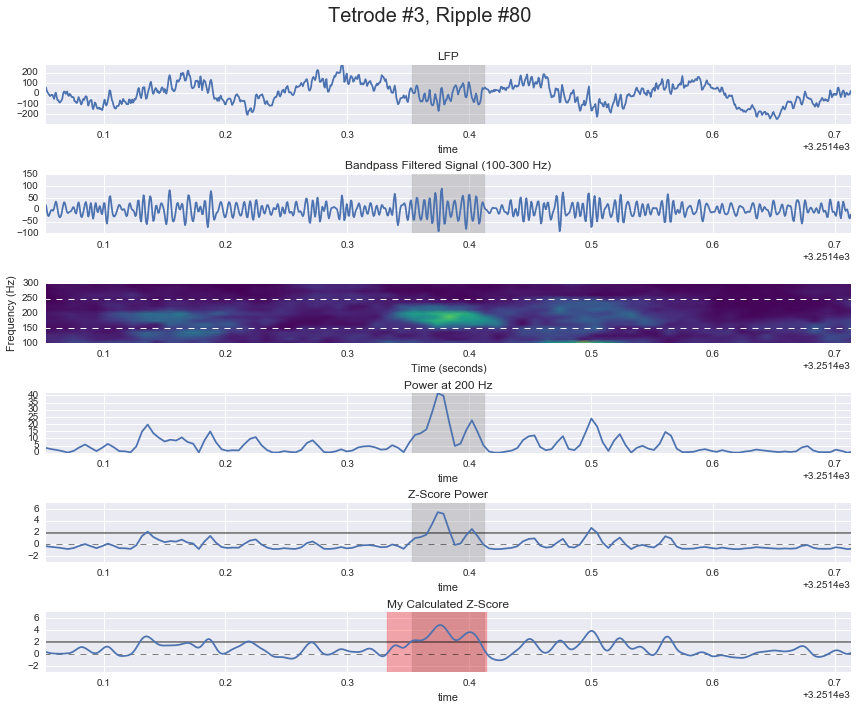

In [244]:
tetrode_numbers = range(1,8)
tetrode_number = random.sample(tetrode_numbers, 1)[0]
sampling_frequency = 1500

ripple_df = ripples.get_multitaper_ripples_dataframe(tetrode_index[tetrode_number - 1], animals,
                                                     sampling_frequency)
ripple_numbers = list(ripple_df.ripple_number.unique())
ripple_number = random.sample(ripple_numbers, 1)[0]

plot_ripple_metrics(ripple_df, ripple_number, sampling_frequency)
plt.subplots_adjust(top=0.90)
plt.suptitle('Tetrode #{tetrode_number}, Ripple #{ripple_number}'.format(tetrode_number=tetrode_number,
                                                                         ripple_number=int(ripple_number)),
             fontsize=20)


In [10]:
def merge_ranges(ranges):
    """
    Merge overlapping and adjacent ranges and yield the merged ranges
    in order. The argument must be an iterable of pairs (start, stop).

    >>> list(merge_ranges([(5,7), (3,5), (-1,3)]))
    [(-1, 7)]
    >>> list(merge_ranges([(5,6), (3,4), (1,2)]))
    [(1, 2), (3, 4), (5, 6)]
    >>> list(merge_ranges([]))
    []
    from: http://codereview.stackexchange.com/questions/21307/consolidate-list-of-ranges-that-overlap
    """
    ranges = iter(sorted(ranges))
    current_start, current_stop = next(ranges)
    for start, stop in ranges:
        if start > current_stop:
            # Gap between segments: output current segment and start a new one.
            yield current_start, current_stop
            current_start, current_stop = start, stop
        else:
            # Segments adjacent or overlapping: merge.
            current_stop = max(current_stop, stop)
    yield current_start, current_stop
    
print(list(merge_ranges([(5,7), (3,5), (-1,3)])))
print(list(merge_ranges([(5,6), (3,4), (1,2)])))
print(list(merge_ranges([])))

[(-1, 7)]
[(1, 2), (3, 4), (5, 6)]
[]


In [177]:
sampling_frequency = 1500
CA1_lfp = df.filter_list_by_pandas_series(lfp_data, cur_tetrode_info.area == 'CA1')
segments_multitaper = [ripples.get_segments_multitaper(lfp, sampling_frequency,
                                                       zscore_threshold=2, minimum_duration=0.015)
                       for lfp in tqdm.tqdm_notebook(CA1_lfp, desc='segments_multitaper')]


In [178]:
merged_segments = list(merge_ranges([seg for tetrode in segments_multitaper for seg in tetrode]))

In [193]:
def get_windowed_dataframe(dataframe, segments, window_offset):
    segments = iter(segments)
    for segment_start, _ in segments:
        yield (dataframe.loc[segment_start + window_offset[0]:segment_start + window_offset[1], :]
                        .reset_index()
                        .drop('time', axis=1))
        
def reshape_to_segments(dataframes, segments, window_offset):
    if isinstance(window_offset, float):
        window_offset = [-window_offset, window_offset]
    num_time_steps = int((window_offset[1] - window_offset[0]) * sampling_frequency) - 1
    time = np.linspace(window_offset[0], window_offset[1], num=num_time_steps)
    for dataframe in tqdm.tqdm_notebook(dataframes, desc='lfp_segments'):
        yield (pd.concat(list(get_windowed_dataframe(dataframe, segments, window_offset)), axis=1)
                  .assign(time=time).set_index('time'))

window_offset  = (-0.200, 0.200)
lfp_segments = list(reshape_to_segments(lfp_data, merged_segments, window_offset))

In [194]:
tetrode_combinations = list(itertools.combinations(range(len(lfp_data)), 2))

# Preset function options
high_frequency_coherence = functools.partial(spectral.get_coherence_dataframe,
                              sampling_frequency=sampling_frequency,
                              time_window_duration=0.020,
                              time_window_step=0.010,
                              desired_frequencies=[100, 300],
                              time_halfbandwidth_product=1,
                              number_of_tapers=1,
                              pad=0)

coherograms = [high_frequency_coherence(lfp_segments[tetrode_ind1], lfp_segments[tetrode_ind2])
               for tetrode_ind1, tetrode_ind2 in tqdm.tqdm_notebook(tetrode_combinations, desc='coherence')]

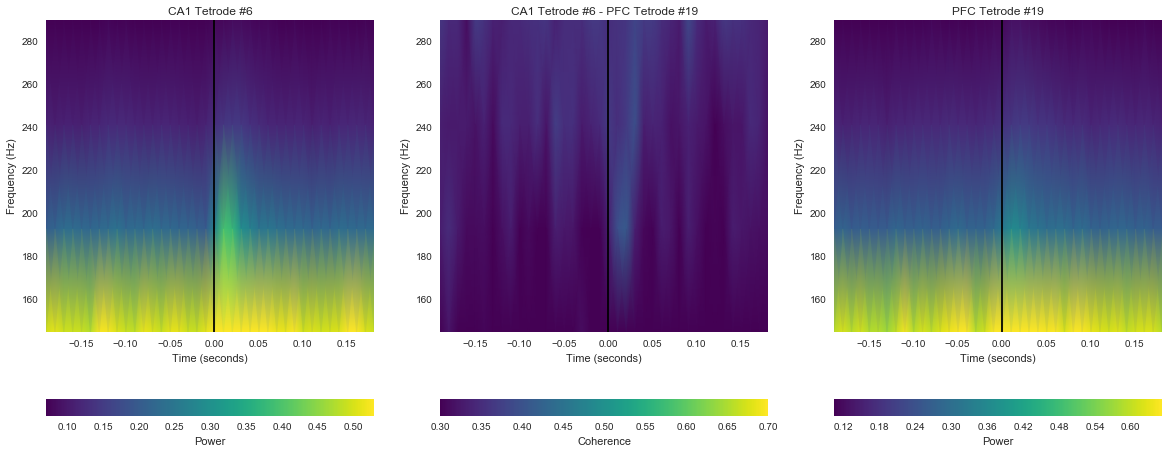

In [292]:
def coherence_title(tetrode_indices, cur_tetrode_info):
    return '{tetrode1} - {tetrode2}'.format(tetrode1=spectral.tetrode_title(tetrode_indices[0], cur_tetrode_info),
                    tetrode2=spectral.tetrode_title(tetrode_indices[1], cur_tetrode_info))

tetrode_combinations_index = [(tetrode_index[tetrode1], tetrode_index[tetrode2])
                              for tetrode1, tetrode2 in tetrode_combinations]

def plot_coherence_pair(tetrode_pair, coherograms, tetrode_combinations, cur_tetrode_info, tetrode_index,
                        cmap='viridis', vmin=0.3, vmax=0.7):
    tetrode_combinations_index = [(tetrode_index[tetrode1], tetrode_index[tetrode2])
                              for tetrode1, tetrode2 in tetrode_combinations]
    pair_ind = tetrode_combinations.index((tetrode_pair[0] - 1,tetrode_pair[1] - 1))
    fig, axis_handles = plt.subplots(1, 3, figsize=(20, 8))
    
    # Spectrogram 1
    mesh = spectral.plot_spectrogram(coherograms[pair_ind], axis_handles[0], spectrum_name='power_spectrum1',
                                     cmap=cmap)
    fig.colorbar(mesh, orientation='horizontal', ax=axis_handles[0], label='Power')
    axis_handles[0].set_title(spectral.tetrode_title(tetrode_combinations_index[pair_ind][0], cur_tetrode_info))
    axis_handles[0].vlines(0, 100, 300)
    # Coherogram
    mesh = spectral.plot_coherogram(coherograms[pair_ind], axis_handles[1],
                                    cmap=cmap, vmin=vmin, vmax=vmax)
    fig.colorbar(mesh, orientation='horizontal', ax=axis_handles[1], label='Coherence')
    axis_handles[1].set_title(coherence_title(tetrode_combinations_index[pair_ind], cur_tetrode_info))
    axis_handles[1].vlines(0, 100, 300)
    
    # Spectrogram 2
    mesh = spectral.plot_spectrogram(coherograms[pair_ind], axis_handles[2], spectrum_name='power_spectrum2',
                                     cmap=cmap)
    fig.colorbar(mesh, orientation='horizontal', ax=axis_handles[2], label='Power')
    axis_handles[2].set_title(spectral.tetrode_title(tetrode_combinations_index[pair_ind][1], cur_tetrode_info))
    axis_handles[2].vlines(0, 100, 300)
    
plot_coherence_pair((6, 19), coherograms, tetrode_combinations, cur_tetrode_info, tetrode_index)

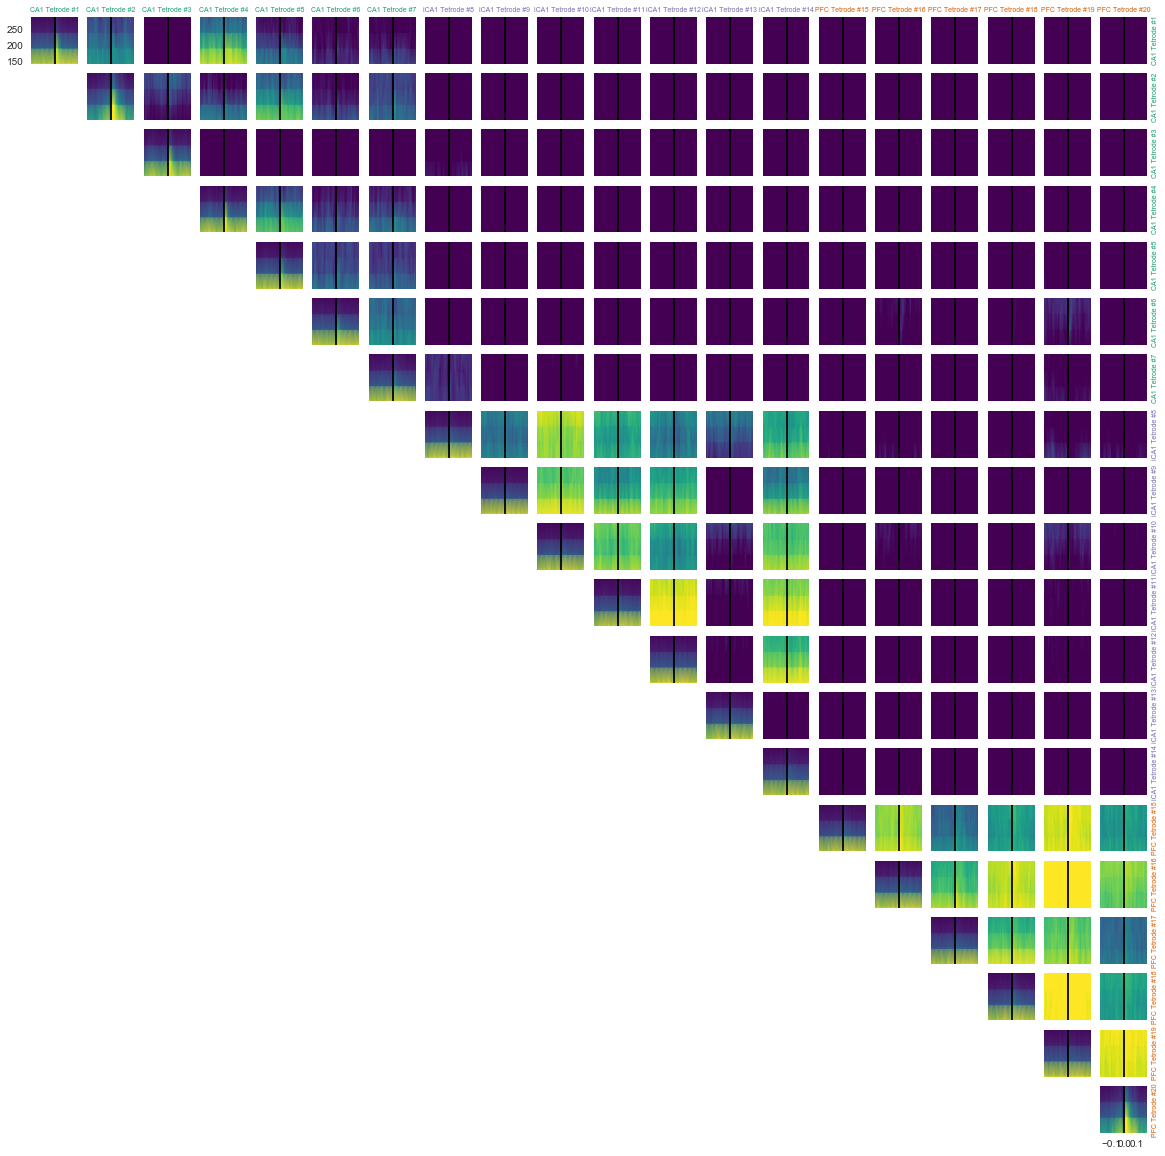

In [277]:
brain_area_to_color = {'CA1': '#1b9e77', 'iCA1': '#7570b3', 'PFC': '#d95f02'}

def plot_tetrode_matrix(cohereogram, tetrode_combinations, tetrode_index, cur_tetrode_info, num_tetrodes,
                        cmap='viridis', vmin=0.3, vmax=0.7):

    fig, axis_handles = plt.subplots(num_tetrodes, num_tetrodes, figsize=(20, 20), sharex=True, sharey=True)

    for pair_ind, (tetrode_ind1, tetrode_ind2) in enumerate(tetrode_combinations):
        mesh = spectral.plot_coherogram(cohereogram[pair_ind], axis_handles[tetrode_ind1, tetrode_ind2],
                                        cmap=cmap, vmin=vmin, vmax=vmax)
        axis_handles[tetrode_ind1, tetrode_ind2].set_xlabel('')
        axis_handles[tetrode_ind1, tetrode_ind2].set_ylabel('')
        axis_handles[tetrode_ind1, tetrode_ind2].locator_params(tight=False, nbins=4)
        if tetrode_ind1 == 0:
            brain_area = cur_tetrode_info.loc[tetrode_index[tetrode_ind2], 'area']
            axis_handles[tetrode_ind1, tetrode_ind2].set_title(spectral.tetrode_title(tetrode_index[tetrode_ind2], cur_tetrode_info),
                                                               fontsize=7, color=brain_area_to_color[brain_area])
        if tetrode_ind2 == num_tetrodes - 1:
            brain_area = cur_tetrode_info.loc[tetrode_index[tetrode_ind1], 'area']
            axis_handles[tetrode_ind1, tetrode_ind2].set_ylabel(spectral.tetrode_title(tetrode_index[tetrode_ind1], cur_tetrode_info),
                                                                fontsize=7, color=brain_area_to_color[brain_area])
            axis_handles[tetrode_ind1, tetrode_ind2].yaxis.set_label_position('right')
        axis_handles[tetrode_ind1, tetrode_ind2].vlines(0, 100, 300)

    for tetrode_ind1, tetrode_ind2 in tetrode_combinations:
        axis_handles[tetrode_ind2, tetrode_ind1].axis('off')

    for tetrode_ind1, tetrode_ind2  in [(ind, ind) for ind in range(0, num_tetrodes)]:
        spectral.plot_spectrogram(cohereogram[tetrode_ind1], axis_handles[tetrode_ind2, tetrode_ind2],
                                  spectrum_name='power_spectrum2', cmap=cmap)
        axis_handles[tetrode_ind2, tetrode_ind2].set_xlabel('')
        axis_handles[tetrode_ind2, tetrode_ind2].set_ylabel('')
        axis_handles[tetrode_ind2, tetrode_ind2].locator_params(tight=False, nbins=4)
        if tetrode_ind2 == 0:
            brain_area = cur_tetrode_info.loc[tetrode_index[tetrode_ind2], 'area']
            axis_handles[tetrode_ind1, tetrode_ind2].set_title(spectral.tetrode_title(tetrode_index[tetrode_ind2], cur_tetrode_info),
                                                               fontsize=7, color=brain_area_to_color[brain_area])
        if tetrode_ind2 == num_tetrodes - 1:
            brain_area = cur_tetrode_info.loc[tetrode_index[tetrode_ind2], 'area']
            axis_handles[tetrode_ind1, tetrode_ind2].set_ylabel(spectral.tetrode_title(tetrode_index[tetrode_ind2], cur_tetrode_info),
                                                                fontsize=7, color=brain_area_to_color[brain_area])
            axis_handles[tetrode_ind1, tetrode_ind2].yaxis.set_label_position('right')
        axis_handles[tetrode_ind2, tetrode_ind2].vlines(0, 100, 300)

num_tetrodes = len(lfp_data)
plot_tetrode_matrix(coherograms, tetrode_combinations, tetrode_index, cur_tetrode_info, num_tetrodes)

In [223]:
tetrode_combinations = list(itertools.combinations(range(len(lfp_data)), 2))

# Preset function options
high_frequency_coherence2 = functools.partial(spectral.get_coherence_dataframe,
                              sampling_frequency=sampling_frequency,
                              time_window_duration=0.040,
                              time_window_step=0.020,
                              desired_frequencies=[100, 300],
                              time_halfbandwidth_product=1,
                              number_of_tapers=1,
                              pad=0)

coherograms2 = [high_frequency_coherence2(lfp_segments[tetrode_ind1], lfp_segments[tetrode_ind2])
               for tetrode_ind1, tetrode_ind2 in tqdm.tqdm_notebook(tetrode_combinations, desc='coherence')]

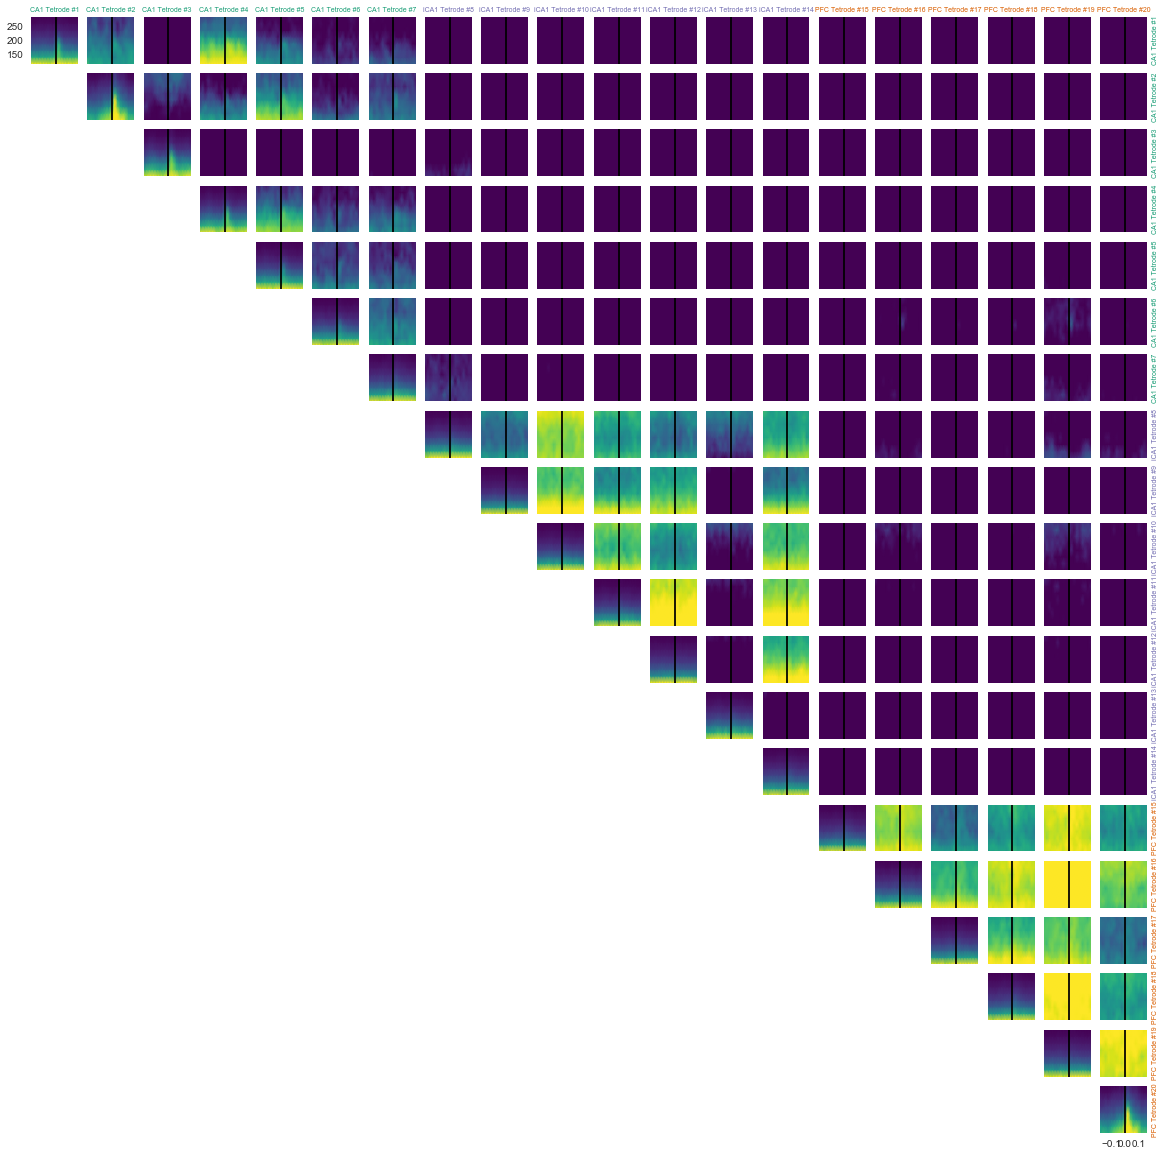

In [278]:
plot_tetrode_matrix(coherograms2, tetrode_combinations, tetrode_index, cur_tetrode_info, num_tetrodes)

In [225]:
tetrode_combinations = list(itertools.combinations(range(len(lfp_data)), 2))

# Preset function options
high_frequency_coherence3 = functools.partial(spectral.get_coherence_dataframe,
                              sampling_frequency=sampling_frequency,
                              time_window_duration=0.080,
                              time_window_step=0.040,
                              desired_frequencies=[100, 300],
                              time_halfbandwidth_product=2,
                              number_of_tapers=3,
                              pad=0)

coherograms3 = [high_frequency_coherence3(lfp_segments[tetrode_ind1], lfp_segments[tetrode_ind2])
               for tetrode_ind1, tetrode_ind2 in tqdm.tqdm_notebook(tetrode_combinations, desc='coherence')]

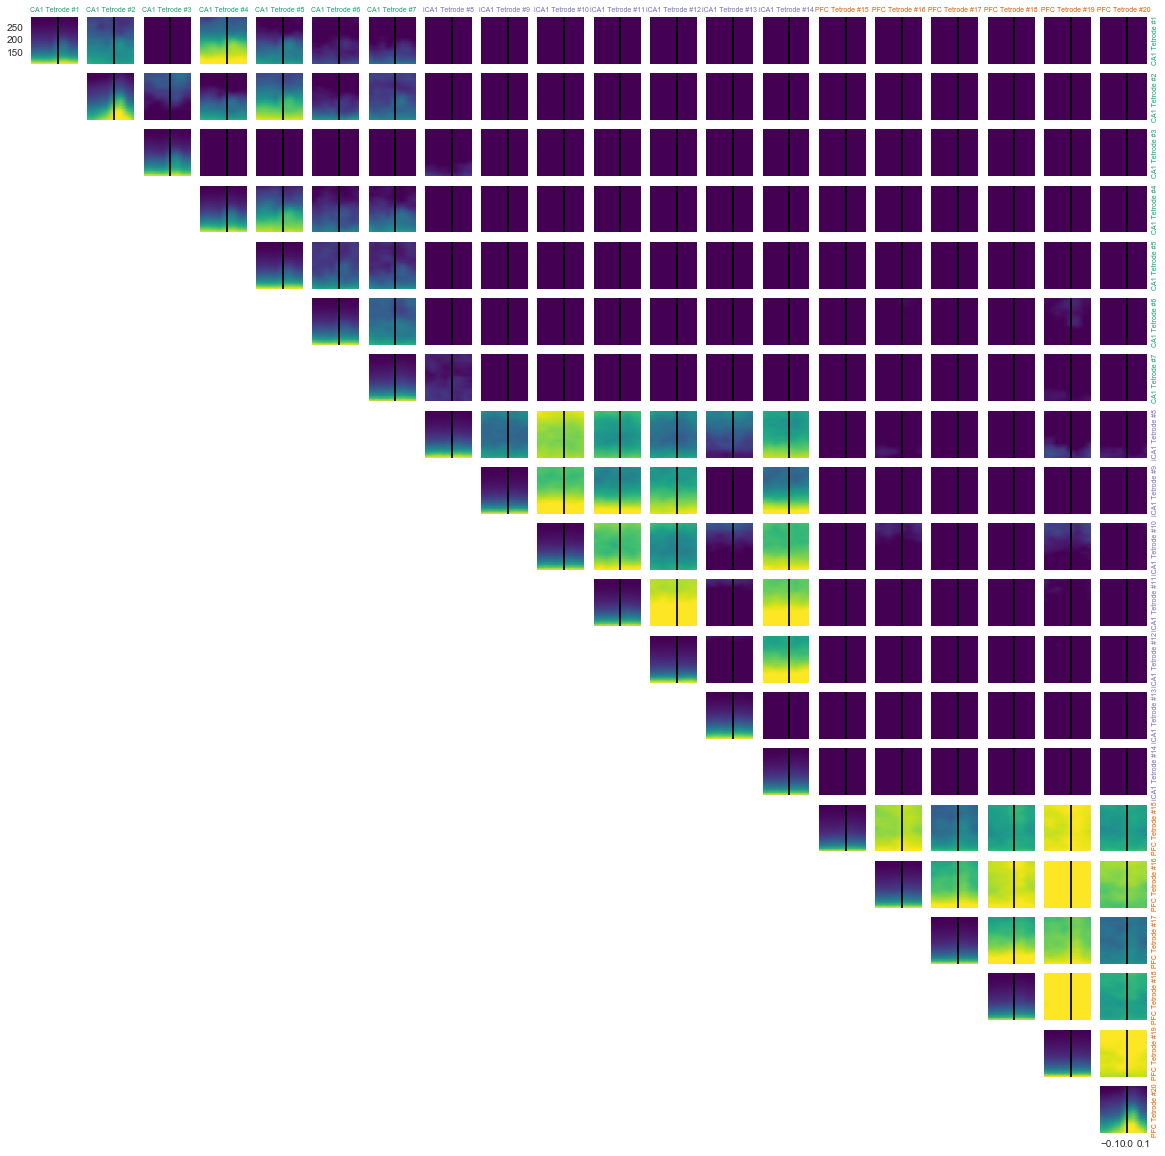

In [279]:
plot_tetrode_matrix(coherograms3, tetrode_combinations, tetrode_index, cur_tetrode_info, num_tetrodes)

In [33]:
window_offset  = (-0.250, -0.050)
lfp_segments_before_ripple = list(reshape_to_segments(lfp_data, merged_segments, window_offset))

window_offset  = (0, 0.200)
lfp_segments_after_ripple = list(reshape_to_segments(lfp_data, merged_segments, window_offset))

In [262]:
coherograms_before = [high_frequency_coherence(lfp_segments_before_ripple[tetrode_ind1], lfp_segments_before_ripple[tetrode_ind2])
                      for tetrode_ind1, tetrode_ind2 in tqdm.tqdm_notebook(tetrode_combinations, desc='coherence')]

coherograms_after = [high_frequency_coherence(lfp_segments_after_ripple[tetrode_ind1], lfp_segments_after_ripple[tetrode_ind2])
                      for tetrode_ind1, tetrode_ind2 in tqdm.tqdm_notebook(tetrode_combinations, desc='coherence')]

coherence_difference = [(after - before).assign(frequency=after.frequency).assign(time=after.time)
                        for after, before
                        in zip(coherograms_after, coherograms_before)]

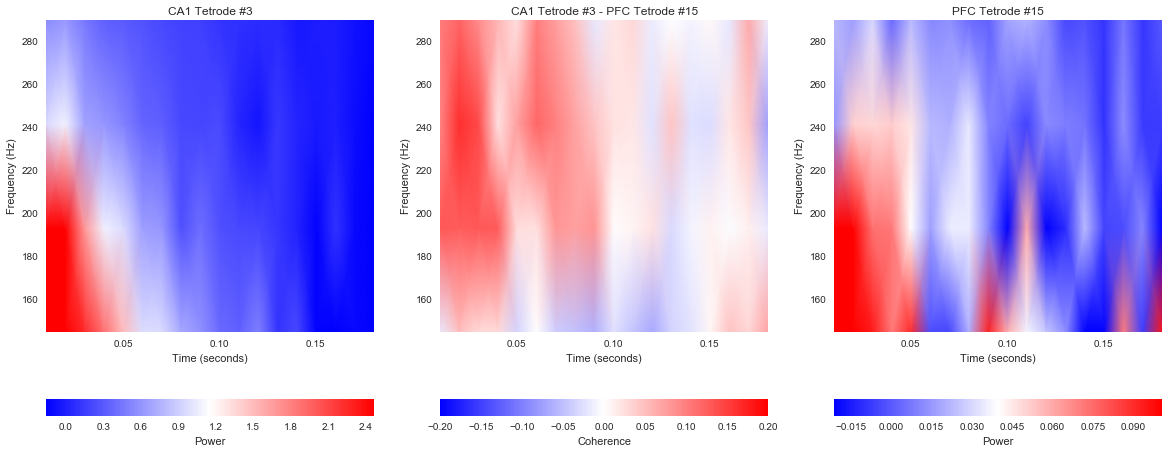

In [301]:
plot_coherence_pair((3, 15), coherence_difference, tetrode_combinations, cur_tetrode_info, tetrode_index,
                    cmap='bwr', vmin=-0.2, vmax=0.2)

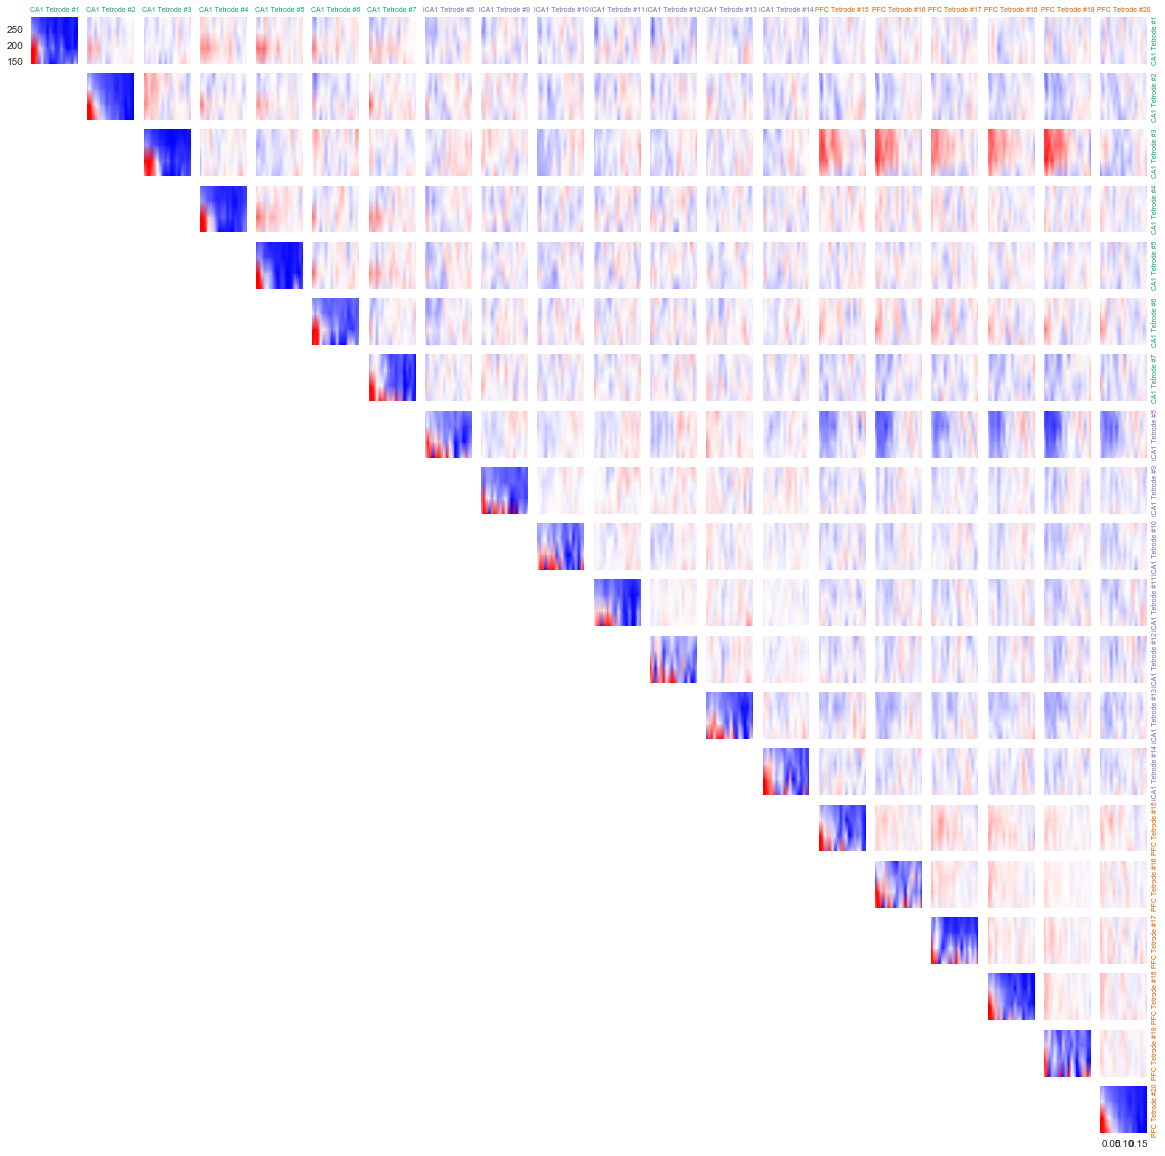

In [280]:
plot_tetrode_matrix(coherence_difference, tetrode_combinations, tetrode_index, cur_tetrode_info, num_tetrodes,
                    cmap='bwr', vmin=-0.2, vmax=0.2)

In [281]:
coherograms_before2 = [high_frequency_coherence2(lfp_segments_before_ripple[tetrode_ind1], lfp_segments_before_ripple[tetrode_ind2])
                      for tetrode_ind1, tetrode_ind2 in tqdm.tqdm_notebook(tetrode_combinations, desc='coherence_before')]

coherograms_after2 = [high_frequency_coherence2(lfp_segments_after_ripple[tetrode_ind1], lfp_segments_after_ripple[tetrode_ind2])
                      for tetrode_ind1, tetrode_ind2 in tqdm.tqdm_notebook(tetrode_combinations, desc='coherence_after')]

coherence_difference2 = [(after - before).assign(frequency=after.frequency).assign(time=after.time)
                        for after, before
                        in zip(coherograms_after2, coherograms_before2)]

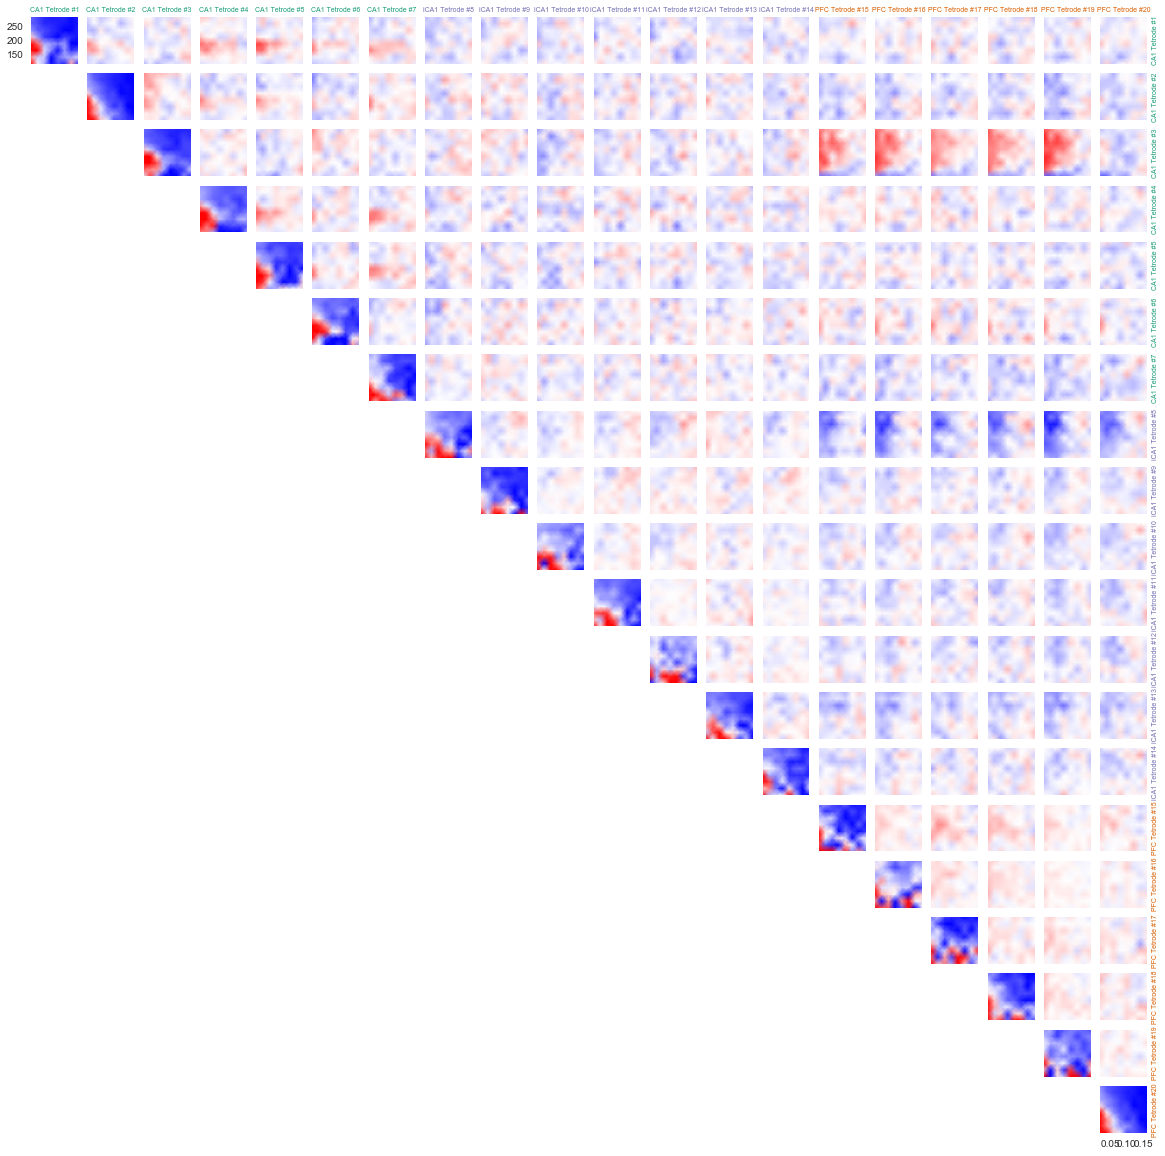

In [282]:
plot_tetrode_matrix(coherence_difference2, tetrode_combinations, tetrode_index, cur_tetrode_info, num_tetrodes,
                    cmap='bwr', vmin=-0.2, vmax=0.2)

In [283]:
coherograms_before3 = [high_frequency_coherence3(lfp_segments_before_ripple[tetrode_ind1], lfp_segments_before_ripple[tetrode_ind2])
                      for tetrode_ind1, tetrode_ind2 in tqdm.tqdm_notebook(tetrode_combinations, desc='coherence_before')]

coherograms_after3 = [high_frequency_coherence3(lfp_segments_after_ripple[tetrode_ind1], lfp_segments_after_ripple[tetrode_ind2])
                      for tetrode_ind1, tetrode_ind2 in tqdm.tqdm_notebook(tetrode_combinations, desc='coherence_after')]

coherence_difference3 = [(after - before).assign(frequency=after.frequency).assign(time=after.time)
                        for after, before
                        in zip(coherograms_after3, coherograms_before3)]

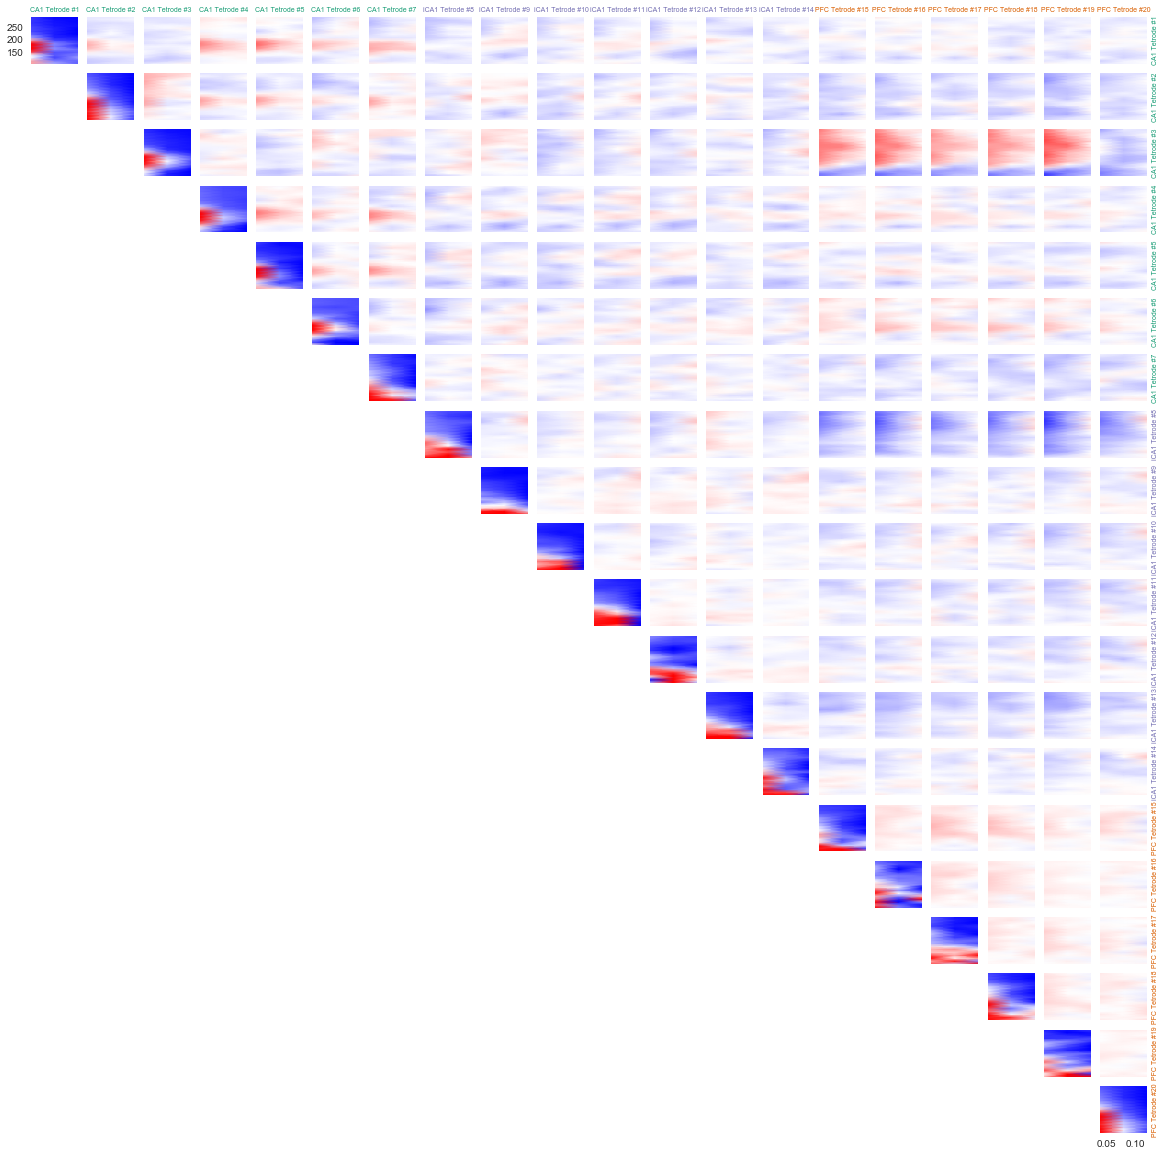

In [302]:
plot_tetrode_matrix(coherence_difference3, tetrode_combinations, tetrode_index, cur_tetrode_info, num_tetrodes,
                    cmap='bwr', vmin=-0.2, vmax=0.2)